In [146]:
import pandas as pd
import numpy as np
import csv

# library for storing and loading objects
import pickle

# library for stemming work
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# library used to make inverted index
from collections import defaultdict
from collections import Counter

# cosine distance
from scipy.spatial.distance import cosine

import math 

# heap_max library
import heapq
from heapq import heappush, heappop

from geopy.geocoders import Nominatim
from geopy import distance
import folium
import os

import functions

# variable declarations
path1 = 'data/docs/'
path2 = '.tsv'
#stemmed_path='data/tokenized_docs/'
#sp = string.punctuation+'“”–’'

# Step 2: Create documents

Importing data from Airbnb_Texas_Rentals.csv and preparing it for pre processing.

We decide to remove from the beginnig the rows of b&b without any location information (latitude or longitute), they are 34 and they won't affect final results. In this way we can properly elaborate the algorithm in step 4.
    

In [20]:
texas1 = pd.read_csv("data/Airbnb_Texas_Rentals.csv")
# dropping duplicates (there are no duplicates)
texas1 = texas1.drop_duplicates()
texas1 = texas1[np.isfinite(texas1['latitude'])]
texas1 = texas1[np.isfinite(texas1['longitude'])]

### 3.1) Preprocessing:

Since every row of the dataframe contains information for a single announcement, we store each row of the dataframe as separated tsv file.


In [12]:
functions.preprocessing(texas1)

# Step 3: Search Engine

### 3.1.1) Create vocabulary and inverted index for search engine 1


We decide to create the vocabulary and inverted index ( _ii1_ ) for the search engine 1 into the same method because it's faster and we elaborate data only once.

We create vocabulary parsing every stemmed document, and we update it when the algorithm finds a new word. Meanwhile we do the same for each term_id into the inverted index: if the document contains a new term we create a new key and we append the document_id _doc-id_, otherwise we append (doc-id) to the already existing term_id.


In [13]:
functions.create_vocabulary_and_ii1(texas1)

### 3.1.2) Execute the query - Search engine 1

As asked in the question 3.1, we made a search engine that returns a set of documents that contain all the terms for each conjunctive query. This search engine refers to the vocabulary and ii1. In the output we print at most k = 5 documents using a dataframe structure.

In [143]:
res = functions.search_engine_1('House with garden')
res

,Title,Description,City,Url
1,2 blocks to Rainey! Walk downtown!,"HOLIDAYS, LOCAL EVENTS, HIGH DEMAND WEEKENDS, ...",Austin,https://www.airbnb.com/rooms/1250575?location=...
2,Sandy Toes Beach Retreat,It's finally here and we are happy to share ou...,Galveston,https://www.airbnb.com/rooms/16980825?location...
3,Private Rm/Bath @ the Gold House!,This unique private guest room at the Gold Hou...,San Antonio,https://www.airbnb.com/rooms/1284796?location=...
4,Gibbs House / Walk to the Beach,Your private suite is in my personal residence...,Galveston,https://www.airbnb.com/rooms/16982846?location...
5,Tudor Home Guest House,Charming 2 bedroom guest house. Large kitchen/...,Dallas,https://www.airbnb.com/rooms/6324590?location=...


## 3.2) Conjunctive query & Ranking score

### 3.2.1) Inverted index (TFIDF)

Creating the inverted index with TFIDF and storing it as pickle binary file.

In [5]:
functions.inverted_index_TFIDF(texas1)

### 3.2.2) Execute the query - Search engine 2

This new search engine uses both of the inverted indexes with TFIDF:

    - It takes the query and it stems it
    - It obtains with ii1 the list of documents which cointain all the terms of the query
    - It makes cosine similarity between each document of the list and the query
    - It returns the first k terms (default k=5)
    
   
We decide not to work with all the terms of the inverted index but only with terms contained in the query.
Since inverted index has more than 10 thousands of rows, we extract only necessary terms to compute faster cosine similarity between smaller arrays. 

To compute the cosine similarity, we consider in the query array the absolute frequency of terms.


In [144]:
res = functions.search_engine_2('Beach, two rooms with private bathroom')
res

,Title,Description,City,Url,Similarity
1,Allegro North First Floor Condo for 7 guests,"Two bedroom, two bathroom condo with master su...",Rockport,https://www.airbnb.com/rooms/18157657?location...,0.864
2,"Condo 305 is Comfortable, Economical on beach",Our home is designed for comfort and convenien...,South Padre Island,https://www.airbnb.com/rooms/11580397?location...,0.855
3,North Padre Island room beach 1M,My wife and I will welcome you into our home a...,Corpus Christi,https://www.airbnb.com/rooms/3767705?location=...,0.855
4,North Padre Island room beach 1M,My wife and I will welcome you into our home a...,Corpus Christi,https://www.airbnb.com/rooms/3767705?location=...,0.855
5,Private Bedroom (queen)/Bathroom in Beautiful ...,Beautiful 3 bedroom/2 bath house (1 private gu...,Corpus Christi,https://www.airbnb.com/rooms/19484822?location...,0.708


# Step 4: Define a new score!

At first, we will make the same as we have done in the question 3.1 with Search Engine 1: we find the documents which satisfy a text query. 

After the text query, the users has to type informations about three different field: 
    - target price
    - the number of rooms needed
    - desired location and the maximum affordable distance from the location.
    
Each rank is bounded between 0 and 1, in this way we are able to make a weighted average.

In this case, the location has the highest priority, followed by price and then the number of rooms which have been considered. Since the location is most important for a search, we gave it a weight 0.7. After that we considered the price more important than the number of rooms. So we gave respectively, 

At the end, for each document we will have the following ranking:

$$\text{rank}_\text{doc_i} = \text{location_rank}\cdot 0.7 + \text{price_rank} \cdot 0.2 + \text{rooms_rank} \cdot 0.1 $$


## Rankings

### 1) Location

For the location we allow the user to type the location and the max_distance. 

Our ranking it's based on a function that, for each document, it computes the distance between the b&b location and the location typed. The value of the ranking decrease linearly with slope $ ({1}/\text{max distance}) $ from the center chosen by the user. The function is the following:

$$  \text{location_rank(distance)}_\text{doc_i}  = 1 -  \frac{\text{distance}}{\text{max_distance}} \quad \forall \text{ distance} \in [0,\text{max_distance}) $$

$$0 \quad \text{otherwise}$$

The measure unit is km. The default value of max_distance is 15.

We thought that it's useless, for an user that is looking for a particular city, to have results of other ones. 

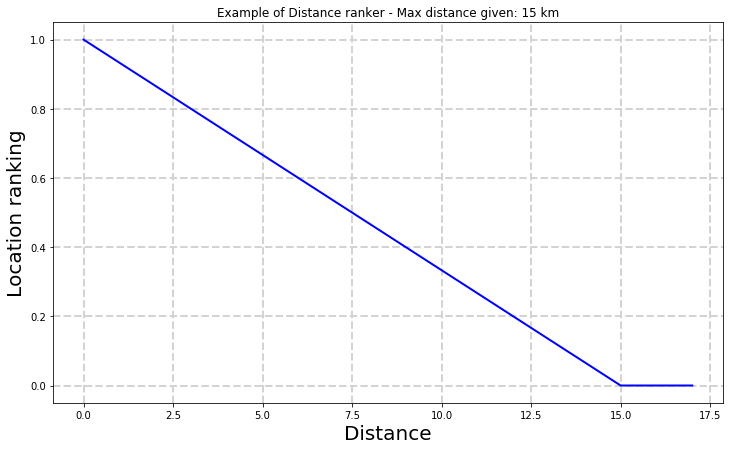

In [142]:
functions.location_rank()

### 2) Target price 

We score the low point if the difference between the target price that users prefer and price of documents is big. 

We decide to make the score as a linear function that decrease linearly with the absolute difference between target price and document price with slope of 0.01. 
In this case we are able to spread ranks related to the target price in a very smooth way. Since we want a rank value between 0 and 1, we had to define properly the domain of our function. 

$$ \text{price_rank}_\text{doc_i} = 1 - \frac{1}{100} \times \left| \text{ price_target} - \text{price_doc_i } \right| $$

As consequence of this decision, in case the difference of price between the preferred price for the user and a high price of the document considered is equal or greater than 100, then it's not given any positive score to the price, so the score is 0.   


#### Trend of ranks for a  fixed price 

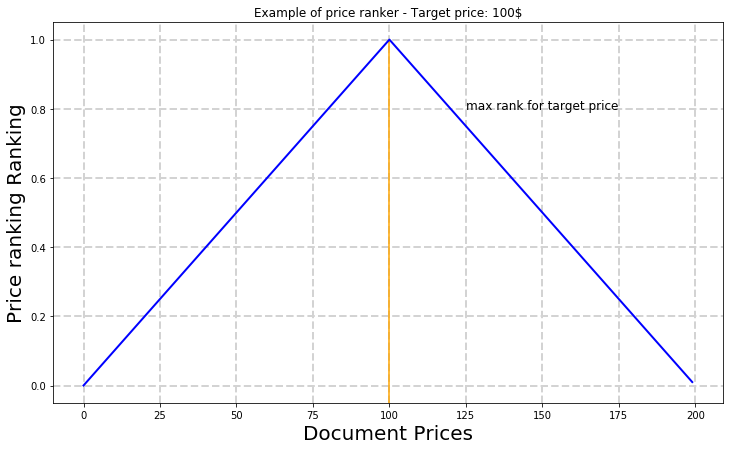

In [125]:
functions.price_rank_100()

### 3) The number of rooms: 

In this case, we compute the difference between the number of rooms needed and the number of rooms available.
For each document, the algorithm is following:

    - 0 if the difference between document is negative or equal and greater than 4
    - 1 if they have the same number of rooms
    - 0.75 if the number of room available
    - and so on and so forth

In this way we give more weight to rooms that come close to the exact number needed. <br>
We decided also to penalize much more houses with less rooms available than those required

# Search engine 4 

In [241]:
res = functions.search_engine_3(input('What are you looking for: '))
res

What are you looking for: House with swimming pool
target price: 
80
n rooms: 
2
location: 
Dallas
max distance from your location(km): 10
Found 81 results


,Ranking,Title,Description,City,Url
0,1,Upscale home with pool... Best location in Dal...,"WELCOME!\n\nMinutes from Uptown, minutes from ...",Dallas,https://www.airbnb.com/rooms/16694156?location...
1,2,Upscale home with pool... Best location in Dal...,"WELCOME!\n\nMinutes from Uptown, minutes from ...",Dallas,https://www.airbnb.com/rooms/16694156?location...
2,3,Upscale home with pool... Best location in Dal...,"WELCOME!\n\nMinutes from Uptown, minutes from ...",Dallas,https://www.airbnb.com/rooms/16694156?location...
3,4,Mi casa es su Casa. Travel instyle.,"Gorgeous 3 master suites w/ privatel baths, al...",Dallas,https://www.airbnb.com/rooms/790791?location=A...
4,5,2 Bedroom Townhome in Mckinney,Beautifully decorated and fully furnished apar...,McKinney,https://www.airbnb.com/rooms/17938617?location...


# Step 4: make nice visualization

In [242]:
location = input('Location: ')
km = input('Radius(km): ')
m = functions.houses_map(location, float(km))

Location: Austin
Radius(km): 2


In [244]:
# EXAMPLE of saving map using os mod
m.save(os.path.join('%s_%s_km_map.html'%(location,km)))